In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/ML Project - Skin Cancer/train-metadata.csv', low_memory=False)
test_data = pd.read_csv('/content/drive/MyDrive/ML Project - Skin Cancer/test-metadata.csv', low_memory=False)

# Drop useless columns in training metadata

In [ ]:
useless_cols = set(train_data.columns) - set(test_data.columns)
useless_cols.remove('target')
useless_cols = list(useless_cols)
train_data = train_data.drop(columns=useless_cols)

In [ ]:
useless_cols

['iddx_full',
 'iddx_1',
 'iddx_2',
 'mel_mitotic_index',
 'mel_thick_mm',
 'tbp_lv_dnn_lesion_confidence',
 'lesion_id',
 'iddx_3',
 'iddx_5',
 'iddx_4']

In [ ]:
train_size = train_data.shape[0]
train_size

401059

# Extract the target for training

In [ ]:
X_train = train_data.drop(columns='target')
y_train = train_data['target']

# Fill absent values

In [ ]:
X_train.fillna({'age_approx': X_train['age_approx'].mean(),'anatom_site_general':'NA','sex':'NA'}, inplace=True)

# Combine the test and training set, after normalization will be split again

In [ ]:
all_data = pd.concat([X_train, test_data])
all_data.reset_index(drop=True, inplace=True)
all_data.shape[0]

401062

In [ ]:
all_data.dtypes

,0
isic_id,object
patient_id,object
age_approx,float64
sex,object
anatom_site_general,object
clin_size_long_diam_mm,float64
image_type,object
tbp_tile_type,object
tbp_lv_A,float64
tbp_lv_Aext,float64


In [ ]:
print(all_data['sex'].dtype)

object


# Drop useless columns in both sets

In [ ]:
all_data = all_data.drop(columns=['copyright_license', 'attribution', 'image_type', 'patient_id'])

# Get the names of numeric and categorical columns

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
col_num = []
col_cat = []
for col in all_data:
  if col in ['isic_id']: continue;
  if all_data[col].dtype == 'object':
    col_cat.append(col)
    all_data[col] = all_data[col].astype('category')
  else:
    col_num.append(col)
    all_data[col] = all_data[col].astype('float64')

# Normalization for numeric columns

In [ ]:
# Normalization for numeric values
numeric_transformer = StandardScaler()
all_data.loc[:,col_num] = numeric_transformer.fit_transform(all_data[col_num])

# One hot encoding for categorical columns.

In [ ]:
categorical_transformer = OneHotEncoder(sparse_output=False)
X_cat = categorical_transformer.fit_transform(all_data[col_cat])
new_cat_col = categorical_transformer.get_feature_names_out(col_cat)
new_cat_col

array(['sex_NA', 'sex_female', 'sex_male', 'anatom_site_general_NA',
       'anatom_site_general_anterior torso',
       'anatom_site_general_head/neck',
       'anatom_site_general_lower extremity',
       'anatom_site_general_posterior torso',
       'anatom_site_general_upper extremity', 'tbp_tile_type_3D: XP',
       'tbp_tile_type_3D: white', 'tbp_lv_location_Head & Neck',
       'tbp_lv_location_Left Arm', 'tbp_lv_location_Left Arm - Lower',
       'tbp_lv_location_Left Arm - Upper', 'tbp_lv_location_Left Leg',
       'tbp_lv_location_Left Leg - Lower',
       'tbp_lv_location_Left Leg - Upper', 'tbp_lv_location_Right Arm',
       'tbp_lv_location_Right Arm - Lower',
       'tbp_lv_location_Right Arm - Upper', 'tbp_lv_location_Right Leg',
       'tbp_lv_location_Right Leg - Lower',
       'tbp_lv_location_Right Leg - Upper', 'tbp_lv_location_Torso Back',
       'tbp_lv_location_Torso Back Bottom Third',
       'tbp_lv_location_Torso Back Middle Third',
       'tbp_lv_location_Tor

In [ ]:
all_data = all_data.drop(columns=col_cat)

In [ ]:
all_data = pd.concat([all_data,pd.DataFrame(X_cat, columns=new_cat_col)],axis=1)

# Return the data to test and training set

In [ ]:
X_train = all_data.iloc[0:train_size,:]
X_test = all_data.iloc[train_size:,:]

In [ ]:
X_test.reset_index(drop=True, inplace=True)

# Take out the id for test and training set

In [ ]:
col_id = ['isic_id']
X_train_id = X_train[col_id]
X_train_data = X_train.drop(columns=col_id)
X_test_id = X_test[col_id]
X_test_data = X_test.drop(columns=col_id)

# Some statistics

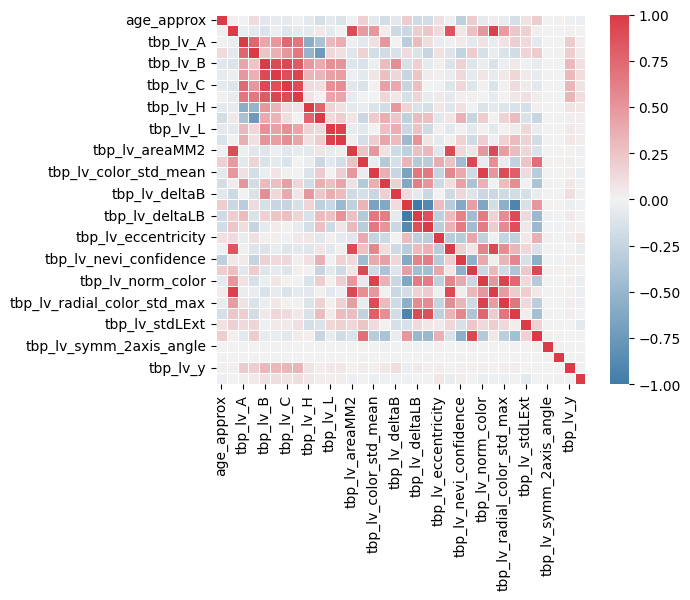

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
data_updated = X_train[col_num]
correlation= data_updated.corr()

# axis_corr = sns.heatmap(
#   correlation,
#   vmin=-1, vmax=1, center=0,
#   cmap=sns.diverging_palette(100, 500, n=500, as_cmap=True),
#   square=True
# )

axis_corr = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(240, 10, n=500, as_cmap=True),  # Blue to red diverging palette
    square=True,
    linewidths=0.5,  # Optional: spacing between cells
)

plt.show()



In [ ]:
type(correlation)

pandas.core.frame.DataFrame

In [ ]:
high_corr = correlation.where(np.abs(correlation) > 0.75).stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
high_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Display the result
high_corr

,Feature 1,Feature 2,Correlation
2,clin_size_long_diam_mm,tbp_lv_areaMM2,0.902768
3,clin_size_long_diam_mm,tbp_lv_minorAxisMM,0.858842
4,clin_size_long_diam_mm,tbp_lv_perimeterMM,0.965004
6,tbp_lv_A,tbp_lv_Aext,0.760407
7,tbp_lv_Aext,tbp_lv_A,0.760407
10,tbp_lv_B,tbp_lv_Bext,0.909632
11,tbp_lv_B,tbp_lv_C,0.920575
12,tbp_lv_B,tbp_lv_Cext,0.827217
13,tbp_lv_Bext,tbp_lv_B,0.909632
15,tbp_lv_Bext,tbp_lv_C,0.885437


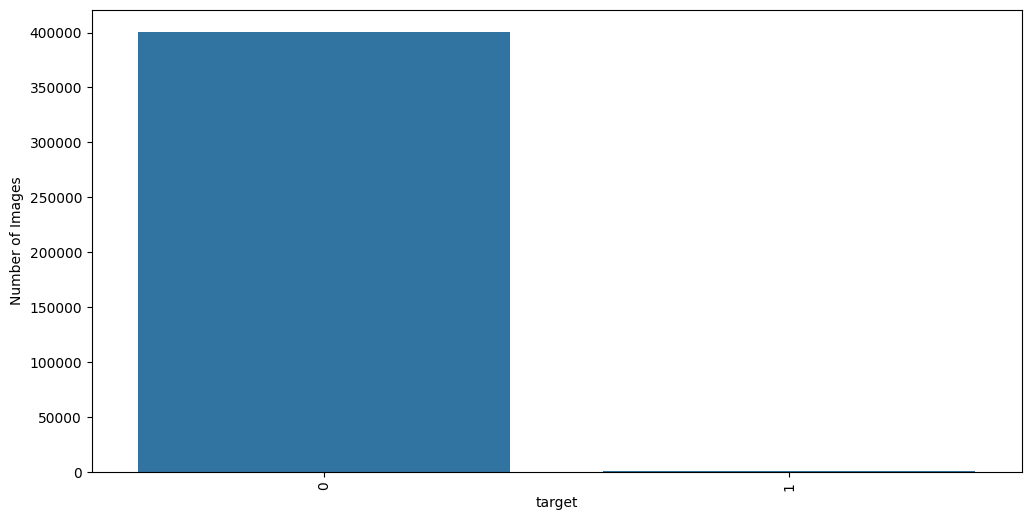

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=train_data)
plt.xlabel('target')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

# The score function

In [ ]:
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC

    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC)
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    # del solution[row_id_column_name]
    # del submission[row_id_column_name]

    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)

    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return(partial_auc)

# Split the training set into training and validation set

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
X_train_data_partial, X_val, y_train_partial, y_val = train_test_split(X_train_data, y_train, test_size=0.2, stratify=y_train)

# This part we will try several naive models

In [ ]:
n_est = 100
model1 = ExtraTreesClassifier(n_estimators=n_est)
model2 = RandomForestClassifier(n_estimators=n_est)

In [ ]:
model1.fit(X_train_data_partial, y_train_partial)
model2.fit(X_train_data_partial, y_train_partial)

In [ ]:
cross_val_score(model1, X_train_data, y_train, cv=4)

array([0.99902259, 0.99902259, 0.99901262, 0.99902258])

In [ ]:
predictions1 = model1.predict_proba(X_val)[:,1]
predictions2 = model2.predict_proba(X_val)[:,1]

In [ ]:
# No need to run this cell, it should be in kaggle notebook
submission = pd.DataFrame(
    {'isic_id': X_test['isic_id'], 'target': predictions},
    columns = ['isic_id', 'target'])
submission.to_csv('submission.csv', index = False)

In [ ]:
score(pd.DataFrame(y_val), pd.DataFrame(predictions1),'isic_id')

0.05309143192299942

In [ ]:
score(pd.DataFrame(y_val), pd.DataFrame(predictions2),'isic_id')

0.04979912562032286

In [ ]:
# Extra Tree with SMOTE
model3 = ExtraTreesClassifier(n_estimators=n_est)
X_resampled, y_resampled = SMOTE().fit_resample(X_train_data_partial, y_train_partial)
model3.fit(X_resampled, y_resampled)
predictions3 = model3.predict_proba(X_val)[:,1]
score(pd.DataFrame(y_val), pd.DataFrame(predictions3),'isic_id')

0.10811166498986571

In [ ]:
len(list(X_train_data_partial.columns))

74

In [ ]:
# PCA processed data for later useage
pca = PCA(n_components=37)
X_pca_train = pca.fit_transform(X_train_data_partial)
X_pca_val = pca.transform(X_val)

In [ ]:
# Extra Tree with SMOTE and PCA
model4 = ExtraTreesClassifier(n_estimators=n_est)
X_resampled_pca, y_resampled_pca = SMOTE().fit_resample(X_pca_train, y_train_partial)
model4.fit(X_resampled_pca, y_resampled_pca)
predictions4 = model4.predict_proba(X_pca_val)[:,1]
score(pd.DataFrame(y_val), pd.DataFrame(predictions4),'isic_id')

0.1224523832121043

In [ ]:
# ADASYN resampled data for later useage
X_clresampled_pca, y_clresampled_pca = ADASYN().fit_resample(X_pca_train, y_train_partial)

In [ ]:
# Extra Tree with ADASYN and PCA
model5 = ExtraTreesClassifier(n_estimators=n_est)
model5.fit(X_clresampled_pca, y_clresampled_pca)
predictions5 = model5.predict_proba(X_pca_val)[:,1]
score(pd.DataFrame(y_val), pd.DataFrame(predictions5),'isic_id')

0.14671707653115298

# Since ADASYN + PCA gives the best score so far, let's find out how many components is best.

In [ ]:
n_comp = [i for i in range(35,55)]
for n in n_comp:
  pca = PCA(n_components=n)
  X_pca_train = pca.fit_transform(X_train_data_partial)
  X_pca_val = pca.transform(X_val)
  X_clresampled_pca, y_clresampled_pca = ADASYN().fit_resample(X_pca_train, y_train_partial)
  model5 = ExtraTreesClassifier()
  model5.fit(X_clresampled_pca, y_clresampled_pca)
  predictions5 = model5.predict_proba(X_pca_val)[:,1]
  print(f'n_components: {n}, score: {score(pd.DataFrame(y_val), pd.DataFrame(predictions5),"isic_id")}')

n_components: 35, score: 0.11204880295189171
n_components: 36, score: 0.12945764285320496
n_components: 37, score: 0.11765449539297035
n_components: 38, score: 0.11328425037678654
n_components: 39, score: 0.12408459859534153
n_components: 40, score: 0.1253446907526083
n_components: 41, score: 0.13886898221580035
n_components: 42, score: 0.11522728360533291
n_components: 43, score: 0.13044791409808615
n_components: 44, score: 0.11078506174764337
n_components: 45, score: 0.12345874350980099
n_components: 46, score: 0.11593403498329592


KeyboardInterrupt: 

# This part we will use dropout.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization
from tensorflow.keras.activations import swish, elu
from tensorflow.keras.optimizers import Adam

pca = PCA(n_components=41)
X_pca_train = pca.fit_transform(X_train_data_partial)
X_pca_val = pca.transform(X_val)
# Resplit the training data for drop out model before resample
X_train_dp, X_val_dp, y_train_dp, y_val_dp = train_test_split(X_pca_train, y_train_partial, test_size=0.2, stratify=y_train_partial)
# Validation data for epoch training
y_val_dp_one_hot = pd.get_dummies(y_val_dp, dtype=int)
validation_set_dp = (X_val_dp, y_val_dp_one_hot)

# Dropout with ADASYN and PCA
X_resampled_dp, y_resampled_dp = ADASYN().fit_resample(X_train_dp, y_train_dp)
# One hot encode y for loss='categorical_crossentropy'
y_resampled_one_hot = pd.get_dummies(y_resampled_dp, dtype=int)
def build_model(input_shape):
    x = Input(shape=input_shape)
    d1 = Dropout(rate=0.1)(x)
    h1 = Dense(8)(d1)
    a1 = Activation(swish)(h1)
    b1 = BatchNormalization()(a1)
    d2 = Dropout(rate=0.5)(b1)
    h2 = Dense(4)(d2)
    a2 = Activation(elu)(h2)
    b2 = BatchNormalization()(a2)
    d3 = Dropout(rate=0.5)(b2)
    h3 = Dense(2)(d3)
    a3 = Activation(swish)(h3)
    b3 = BatchNormalization()(a3)
    d4 = Dropout(rate=0.5)(b3)
    h4 = Dense(2)(d4)
    p = Activation('softmax')(h4)
    model = Model(inputs=x, outputs=p)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model6 = build_model((X_resampled_dp.shape[1],))

In [ ]:
y_resampled_one_hot.head()

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [ ]:
# Train the model
model6.fit(X_resampled_dp, y_resampled_one_hot, epochs=20, batch_size=64, validation_data=validation_set_dp)

Epoch 1/20
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.6845 - loss: 0.5682 - val_accuracy: 0.8795 - val_loss: 0.2994
Epoch 2/20
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.7510 - loss: 0.4724 - val_accuracy: 0.8633 - val_loss: 0.3202
Epoch 3/20
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7525 - loss: 0.4689 - val_accuracy: 0.8745 - val_loss: 0.3056
Epoch 4/20
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7516 - loss: 0.4669 - val_accuracy: 0.8685 - val_loss: 0.3151
Epoch 5/20
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.7526 - loss: 0.4667 - val_accuracy: 0.8796 - val_loss: 0.2947
Epoch 6/20
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7536 - loss: 0.4640 - val_accuracy: 0.8971 - val_loss: 0.2683
Epoch 7/20
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.7543 - loss: 0.4636 - val_accuracy: 0.8862 - val_loss: 0.2854
Epoch 8/20
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.7565 - loss: 0

In [ ]:
predictions6 = model6.predict(X_pca_val)[:,1]
score(pd.DataFrame(y_val), pd.DataFrame(predictions6),'isic_id')

2507/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


0.12576060653593776

# Models using RBMs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.1)
        self.hidden_bias = nn.Parameter(torch.zeros(n_hidden))
        self.visible_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_hidden(self, visible):
        hidden_activations = torch.mm(visible, self.W) + self.hidden_bias
        hidden_probs = torch.sigmoid(hidden_activations)
        return hidden_probs

    def sample_visible(self, hidden):
        visible_activations = torch.mm(hidden, self.W.t()) + self.visible_bias
        visible_probs = torch.sigmoid(visible_activations)
        return visible_probs

class OptimizedRBMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 reduction_ratio=0.5,
                 enhancement_ratio=0.3,
                 n_epochs=10,
                 batch_size=32,
                 learning_rate=0.01,
                 n_estimators=100):
        """
        Parameters:
        reduction_ratio: float, percentage of original features to keep in reduction
        enhancement_ratio: float, percentage of new features to add
        n_epochs: int, number of epochs for RBM training
        batch_size: int, batch size for RBM training
        learning_rate: float, learning rate for RBM
        n_estimators: int, number of trees in Extra Trees Classifier
        """
        self.reduction_ratio = reduction_ratio
        self.enhancement_ratio = enhancement_ratio
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators

    def _train_rbm(self, rbm, data_tensor):
        """Train the RBM model"""
        optimizer = optim.Adam(rbm.parameters(), lr=self.learning_rate)

        for epoch in range(self.n_epochs):
            epoch_error = 0
            for i in range(0, len(data_tensor), self.batch_size):
                batch = data_tensor[i:i + self.batch_size]

                # Positive phase
                positive_hidden = rbm.sample_hidden(batch)

                # Negative phase
                negative_visible = rbm.sample_visible(positive_hidden)
                negative_hidden = rbm.sample_hidden(negative_visible)

                # Update weights
                optimizer.zero_grad()
                loss = torch.mean((batch - negative_visible) ** 2)
                loss.backward()
                optimizer.step()

                epoch_error += loss.item()

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch + 1}/{self.n_epochs}, Error: {epoch_error/len(data_tensor):.4f}")

    def _get_important_features(self, X, y, n_features):
        """Get indices of most important features"""
        clf = ExtraTreesClassifier(n_estimators=50, random_state=42)
        clf.fit(X, y)
        importance_indices = np.argsort(clf.feature_importances_)[-n_features:]
        return importance_indices

    def fit(self, X, y):
        """Fit the classifier"""
        X_scaled = X

        # Convert to tensor
        X_tensor = torch.FloatTensor(X_scaled)

        # Calculate dimensions for reduction and enhancement
        n_samples, n_features = X.shape
        n_reduced = max(1, int(n_features * self.reduction_ratio))
        n_enhanced = max(1, int(n_features * self.enhancement_ratio))

        # First RBM for reduction
        print("Training reduction RBM...")
        self.reduction_rbm = RBM(n_features, n_reduced)
        self._train_rbm(self.reduction_rbm, X_tensor)

        # Get reduced features
        with torch.no_grad():
            reduced_features = self.reduction_rbm.sample_hidden(X_tensor).numpy()

        # Train classifier on reduced features to check importance
        temp_clf = ExtraTreesClassifier(n_estimators=50, random_state=42)
        temp_clf.fit(reduced_features, y)

        # Keep only important reduced features
        importance_threshold = np.percentile(temp_clf.feature_importances_, 50)
        important_indices = temp_clf.feature_importances_ > importance_threshold
        self.important_reduced_indices = important_indices

        reduced_important = reduced_features[:, important_indices]

        # Second RBM for enhancement
        print("\nTraining enhancement RBM...")
        self.enhancement_rbm = RBM(reduced_important.shape[1], n_enhanced)
        self._train_rbm(self.enhancement_rbm, torch.FloatTensor(reduced_important))

        # Get enhanced features
        with torch.no_grad():
            enhanced_features = self.enhancement_rbm.sample_hidden(
                torch.FloatTensor(reduced_important)
            ).numpy()

        # Combine important reduced and enhanced features
        self.final_features = np.hstack([reduced_important, enhanced_features])

        # Train final classifier
        self.classifier = ExtraTreesClassifier(
            n_estimators=self.n_estimators,
            random_state=42
        )
        self.classifier.fit(self.final_features, y)

        return self

    def predict_proba(self, X):
        """Predict class probabilities"""
        # Transform input data
        X_scaled = X
        X_tensor = torch.FloatTensor(X_scaled)

        # Get reduced features
        with torch.no_grad():
            reduced_features = self.reduction_rbm.sample_hidden(X_tensor).numpy()
            reduced_important = reduced_features[:, self.important_reduced_indices]

            # Get enhanced features
            enhanced_features = self.enhancement_rbm.sample_hidden(
                torch.FloatTensor(reduced_important)
            ).numpy()

        # Combine features
        final_features = np.hstack([reduced_important, enhanced_features])

        return self.classifier.predict_proba(final_features)

    def predict(self, X):
        """Predict classes"""
        return np.argmax(self.predict_proba(X), axis=1)


In [ ]:
rbm_clf = OptimizedRBMClassifier(
        reduction_ratio=0.5,
        enhancement_ratio=0.3,
        n_epochs=10
    )
X_clresampled, y_clresampled = ADASYN().fit_resample(X_train_data_partial, y_train_partial)
rbm_clf.fit(np.array(X_clresampled), y_clresampled)

Training reduction RBM...
Epoch 5/10, Error: 0.0148
Epoch 10/10, Error: 0.0148

Training enhancement RBM...
Epoch 5/10, Error: 0.0000
Epoch 10/10, Error: 0.0000


In [ ]:
rbm_preds = rbm_clf.predict_proba(X_val)
score(pd.DataFrame(y_val), pd.DataFrame(rbm_preds[:,1]),'isic_id')

0.10766384746119066